# Assignment 02 Part 2: Neural Net Template

This file contains the template code for the Neural Net with hidden layers.

### Artificial Neural Net Class

In [1]:
# Widen the Jupyter Notebook
from IPython.display import display, HTML
display(HTML(data="""
<style>
    div#notebook-container    { width: 70%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import math                            

class ANN:

    #==========================================#
    # The init method is called when an object #
    # is created. It can be used to initialize #
    # the attributes of the class.             #
    #==========================================#
    def __init__(self, dimensions = [],
                 activation=[],loss='mse',max_iterations=3, 
                 learning_rate=1,alpha=0,dropout=0,normalisation = 'uniform'):
        self.dropout = dropout       # Dropout rate
        self.loss = loss             # Loss function
        self.alpha = alpha           # Hyperparameter for relu function and other variants
        self.activation = activation         # Activation function list
        self.no_outputs = dimensions[-1]     # No. of output 
        self.no_inputs = dimensions[0]       # No. of input
        self.no_hidden_layers = len(dimensions) - 2     # No. of hidden layer 
        self.hidden_layer_size = dimensions[1:-1]       # Sizes of hidden layers
        self.max_iterations = max_iterations            # No. of epoch
        self.learning_rate = learning_rate              # Learning rate
        self.normalisation = normalisation              
        # Normalisation methods : Uniform / Normal distributions
        if self.normalisation == 'uniform':
            self.weights = [np.random.uniform(-4*np.sqrt(6/(dimensions[i-1]+dimensions[i])),
                                              4*np.sqrt(6/(dimensions[i-1]+dimensions[i])),
                                              (dimensions[i],dimensions[i+1])).T for i in range(len(dimensions)-1)]
            self.bias = [np.random.uniform(-4*np.sqrt(6/(dimensions[i-1]+dimensions[i])),
                                           4*np.sqrt(6/(dimensions[i-1]+dimensions[i])),
                                           (dimensions[i])) for i in range(1,len(dimensions))]
        elif self.normalisation == 'normal':
            self.bias = [np.random.normal(0,np.sqrt(32/(dimensions[i-1]+dimensions[i])),
                                          dimensions[i]) for i in range(1,len(dimensions))]
            self.weights = [np.random.normal(0,np.sqrt(32/(dimensions[i]+dimensions[i+1])),
                                             (dimensions[i],dimensions[i+1])).T for i in range(len(dimensions)-1)]
        else:
            raise ValueError("Normalisation is not supported, please use 'uniform' or 'normal' instead.")
            
    def print_details(self):
        print("No. inputs:\t" + str(self.no_inputs))
        print("No. outputs:\t" + str(self.no_outputs))
        print("No. hidden layers:\t" + str(self.no_hidden_layers))
        print("Hidden layer size:\t" + str(self.hidden_layer_size))
        print("Max iterations:\t" + str(self.max_iterations))
        print("Learning rate:\t" + str(self.learning_rate))
        print("Hyperparameter Alpha:\t" + str(self.alpha))
        print("Dropout rate:\t" + str(self.dropout))
        print("Normalisation:\t" + str(self.normalisation))
        print("Loss function:\t" + str(self.loss))
    #===================================#
    # Performs the activation function. #
    # Expects an array of values of     #
    # shape (1,N) where N is the number #
    # of nodes in the layer.            #
    #===================================#
    
    def activate(self, a, layer):
        if self.activation[layer] == 'sigmoid':
            f = lambda x: 1 if x>10 else(0 if x<-10 else 1/(1 + np.exp(-x)))            # Avoid overflow by clipping
            return np.array([f(o) for o in a])
      
        elif self.activation[layer] == 'softmax':
            a = a - max(a)               # Avoid overflow by substracting each element with the maximum of the array
            r = np.exp(a) 
            return r / r.sum()
        
        elif self.activation[layer] == 'tanh':  
            return 1 / (1 + np.exp(-a))
        
        elif self.activation[layer] == 'relu':
            f = lambda x: x if x > 0 else 0
            return np.array([f(o) for o in a])
        
        elif self.activation[layer] == 'leaky_relu':
            f = lambda x: x if x>0 else self.alpha*x
            return np.array([f(o) for o in a])
        
        elif self.activation[layer] == 'elu':
            f = lambda x: x if x>0 else self.alpha*(np.exp(x)-1)
            return np.array([f(o) for o in a])
    
    def Update(self,output,yi):
        per_node = self.Dloss(output,yi)            # Start back propagation from the derivative of loss function 
        update_weights = []               
        update_bias = []
        for i in range(len(self.activation)-1,-1,-1):           
            outputs = self.output_list[i+1]         # Get output from output list, which is used in calculating derivative
            if self.activation[i] == 'sigmoid':
                per_node = per_node.dot(self.weights[i+1]) # Dot product to collect errors from layer i+1 to nodes in layer i
                per_node = per_node*outputs*(1-outputs)   # Collected error of each node is then multiplied by the derivative 
                                                          # of sigmoid function.
            elif self.activation[i] == 'softmax':
                per_node = per_node.dot(self.weights[i+1])      # Collecting errors
                outputs = outputs.reshape(1,-1)     # Reshape output for later use of calculating hessian matrix          
                hessian_matrix = (outputs*np.identity(outputs.size) - outputs.T@outputs) # Derivative of Softmax is a 2D array 
                per_node = per_node.dot(hessian_matrix)   # Calculating errors in later i 
                
            elif self.activation[i] == 'tanh':
                per_node = per_node.dot(self.weights[i+1])   # Same procedure for other functions
                per_node = per_node*(1 - output*output) 
                
            elif self.activation[i] == 'relu':
                f = lambda x: 1 if x>0 else 0
                per_node = per_node.dot(self.weights[i+1])
                per_node = per_node*np.array([f(o) for o in outputs])
                
            elif self.activation[i] == 'leaky_relu':
                f = lambda x: 1 if x>0 else self.alpha
                per_node = per_node.dot(self.weights[i+1])
                per_node = per_node*np.array([f(o) for o in outputs])
            
            elif self.activation[i] == 'elu':
                f = lambda x: 1 if x>0 else self.alpha*np.exp(x)
                per_node = Dloss*np.array([f(o) for o in outputs])
    
            update_bias.insert(0,per_node)       # Insert bias of layer i to bias update list.         
            result = np.outer(per_node,self.output_list[i])     # Calculating weights for update
            update_weights.insert(0,result)      # Insert weights matrix into weights update list
            
        return update_weights,update_bias
    
    def calculate_WS(self,X,b,w):        
        w = np.squeeze(w)       # Squeeze function to turn shapes like (1,3) into (3,)
        X = np.squeeze(X)
        return w.dot(X) + b
    
    def Dloss(self,output,label):
        if self.loss == 'mse': 
            return  - (output - label)           # Derivative of MSE
z
        elif self.loss == 'crossentropy':
            epsilon = 0.0001
            return label/(output+epsilon)        # Derivative of Cross Entropy.Epsilon to avoid output being zero.
                                                 # It is supposed to return the opposite the formula shown here according 
                                                 # To the textbook, I found it does not work so I removed the minus symbol.
    #===============================#
    # Trains the net using labelled #
    # training data.                #
    #===============================#
    def train(self, X, y):
        # Feed forward stage
        assert len(X) == len(y)
        y_encoded = self.label_encoder(y)               # Label encoder to one-hot encode labels
        self.weights.append(np.identity(self.no_outputs))        # Identity matrix serves as connection from last output to
        if self.dropout:                                         # loss function
            # Dropout in place
            for epoch in range(self.max_iterations):
                for i in range(X.shape[0]):
                    self.output_list = []      # Refreshing output list for each training data
                    Xi = X[i]
                    yi = y_encoded[i]
                    inputs = Xi
                    self.output_list.append(inputs)   # Collecting outputs of each layer for later use in back propagation
                    for j in range(len(self.activation)):      
                        dropout_matrix = self.weights[j]*np.random.choice([True,False],  # Randomly cut off connections
                                                                          self.weights[j].shape, # Between nodes
                                                                          p = [1-self.dropout,self.dropout])
                        activation = self.calculate_WS(inputs,self.bias[j],dropout_matrix)
                        outputs = self.activate(activation,j)
                        self.output_list.append(outputs)
                        inputs = outputs.copy()
                    # Backpropagation stage
                    update_weights,update_bias = self.Update(outputs,yi)
                    for k in range(len(update_weights)):
                        # Updating weights matrix and bias
                        self.weights[k] = self.weights[k] + self.learning_rate*update_weights[k]
                        self.bias[k] = self.bias[k] + self.learning_rate*update_bias[k]
                        
                    if (i+1) % 10000 == 0:
                        print('Batch',(i+1)//10000 + epoch*6)
                        self.test(X,y)
        
        else:
            # Dropout not in place
            # Same procedure as above but without drop out
            for epoch in range(self.max_iterations):   
                for i in range(X.shape[0]):
                    self.output_list = []
                    Xi = X[i]
                    yi = y_encoded[i]
                    inputs = Xi
                    self.output_list.append(inputs)
                    for j in range(len(self.activation)):
                        activation = self.calculate_WS(inputs,self.bias[j],self.weights[j])
                        outputs = self.activate(activation,j)
                        self.output_list.append(outputs)
                        inputs = outputs.copy()

                    # Backpropagation stage
                    update_weights,update_bias = self.Update(outputs,yi)
                    for k in range(len(update_weights)):
                        self.weights[k] = self.weights[k] + self.learning_rate*update_weights[k]
                        self.bias[k] = self.bias[k] + self.learning_rate*update_bias[k]
                        
                    if (i+1) % 10000 == 0:
                        print('Batch',(i+1)//10000 + epoch*6)
                        self.test(X,y)
                        
    #=========================================#
    # Tests the prediction on each element of #
    # the testing data. Prints the precision, #
    # recall, and accuracy.                   #
    #=========================================#
    def test(self,X,y):
        # Initialise confusion matrix
        confusion_matrix = np.zeros((self.no_outputs,self.no_outputs)).astype('int')
        # Feed forward testing
        y = self.label_encoder(y)
        for i in range(X.shape[0]):
            Xi = X[i]
            yi = y[i]
            inputs = Xi
            for j in range(len(self.activation)):
                activation = self.calculate_WS(inputs,self.bias[j],self.weights[j])
                output = self.activate(activation,j)
                inputs = output
            # Filling confusion matrix. Rows stands for true labels, columns for predicted labels
            confusion_matrix[np.where(yi==1)[0][0]][np.argmax(output)] += 1  
            
        # Printing confusion matrix and classification report
        print("Accuracy:\t"+str(confusion_matrix.diagonal().sum() / X.shape[0]),'\n')
        print('Confusion Matrix:')
        print(confusion_matrix,'\n')
        print('Classification Report:','\n')
        print('\t','precision','\t\t','recall','\t\t','f1','\t\t\t\t','support')
        avg_precision = avg_recall = avg_f1 = support = 0
        for i in range(self.no_outputs):
            avg_precision += confusion_matrix[i][i]/confusion_matrix[:,i].sum()
            avg_recall += confusion_matrix[i][i]/confusion_matrix[i,:].sum()
            avg_f1 += 2/((confusion_matrix[:,i].sum()+confusion_matrix[i,:].sum())/confusion_matrix[i][i])
            support +=  confusion_matrix[i][i]
            print(i,'\t',
                  confusion_matrix[i][i]/confusion_matrix[:,i].sum(),'\t',
                  confusion_matrix[i][i]/confusion_matrix[i,:].sum(),'\t',
                 2/((confusion_matrix[:,i].sum()+confusion_matrix[i,:].sum())/confusion_matrix[i][i]),'\t',
                 confusion_matrix[i][i])
        print('total','\t',avg_precision/self.no_outputs,'\t',avg_recall/self.no_outputs,
              '\t',avg_f1/self.no_outputs,'\t',support)
        
    def label_encoder(self,label):      # One-hot encoder
        return np.eye(self.no_outputs)[label]
      
    def show(self,pic = None):         # Printing MNIST data if supplied, else printing weights matrix
        if pic is not None:
            plt.imshow(pic.reshape(28,28), cmap='gray')
        
        else:
            f = plt.figure(figsize=(15,30))
            column = 5
            row = 0
            count = 1
            for layer in range(self.no_hidden_layers+1):
                row += math.ceil(self.weights[0].shape[0]/5)
            for layer in range(self.no_hidden_layers+1):
                dimension = np.sqrt(self.weights[layer].shape[1]).astype('int')
                for i in range(self.weights[layer].shape[0]):
                    f.add_subplot(row,column,count)
                    count +=1
                    plt.imshow(self.weights[layer][i].reshape(dimension,dimension), cmap='gray')
                for j in range(math.ceil(self.weights[layer].shape[0]/column)*column - self.weights[layer].shape[0]):
                    f.add_subplot(row,column,count)
                    count +=1
                    plt.imshow(np.zeros([dimension,dimension]))

### Main method

The following cell(s) should complete parts 2.1 to 2.5.

## 2.1 Loading data, creating an instance of neural net, training and testing 

In [2]:
# Neural Net for binary classification with 2 output nodes 
ann = ANN(dimensions=[784,25,2],activation=['sigmoid','sigmoid'],
          loss='mse',learning_rate=0.01,max_iterations=1,alpha = 0.05)
ann.print_details()

No. inputs:	784
No. outputs:	2
No. hidden layers:	1
Hidden layer size:	[25]
Max iterations:	1
Learning rate:	0.01
Hyperparameter Alpha:	0.05
Dropout rate:	0
Normalisation:	uniform
Loss function:	mse


In [3]:
import pandas as pd
train = pd.read_csv(r'D:\Jupyter Notebooks\Course semester 2\DP and NN\Assignment2\mnist_train.csv',header = None)
train_data = train.values 
for i in range(train.shape[0]):   
    if train_data[i][0] != 7:     # Labels of non-7s changed to 0
        train_data[i][0] = 0      
    else:
        train_data[i][0] = 1      # Labels of 7s changed to 1 
train_label = train_data.T[0]     # Get the training labels 
train_data = train_data[:,1:]     # Get the training data
train_data = train_data/255.0     # Compress numbers into [0,1]

In [4]:
test = pd.read_csv(r'D:\Jupyter Notebooks\Course semester 2\DP and NN\Assignment2\mnist_test.csv',header = None)
test_data = test.values 
for i in range(test.shape[0]):   
    if test_data[i][0] != 7:     # Labels of non-7s changed to -1 
        test_data[i][0] = 0      
    else:
        test_data[i][0] = 1          
test_label = test.values.T[0]     # Get the testing labels 
test_data = test.values[:,1:]     # Get the testing data
test_data = test_data/255.0     

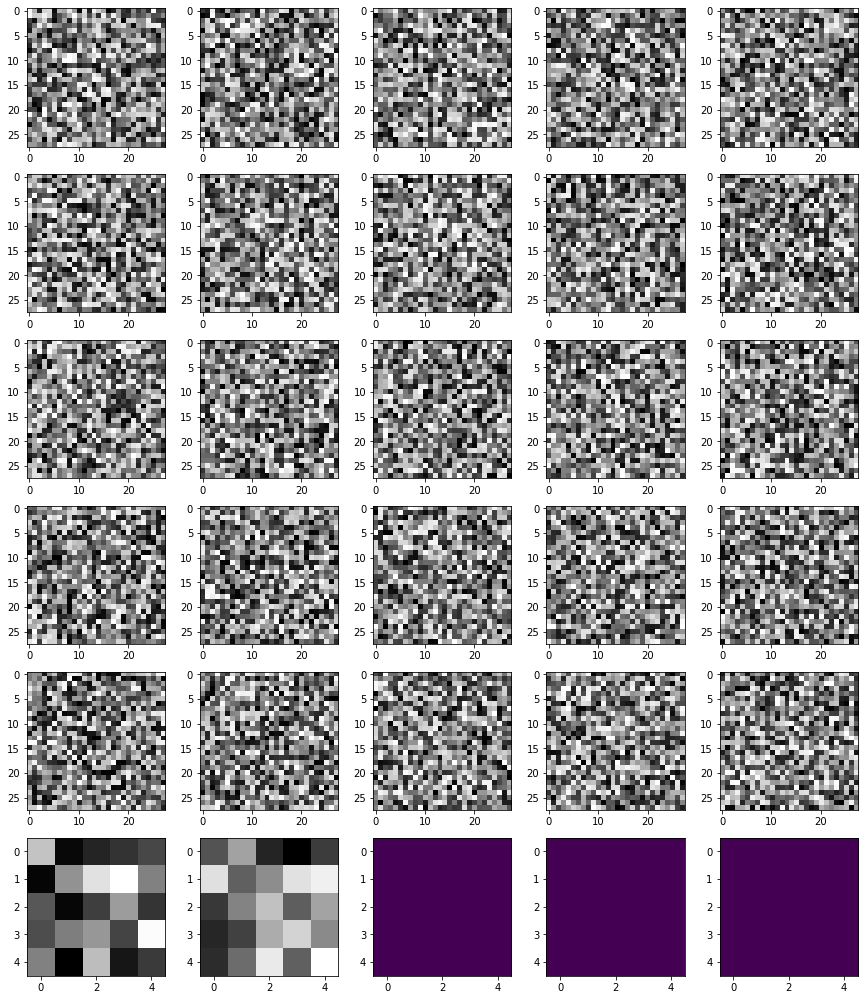

In [5]:
# Visualising the initial weights matrix
ann.show()

In [6]:
%%time
ann.train(train_data,train_label)

Batch 1
Accuracy:	0.9484333333333334 

Confusion Matrix:
[[53682    53]
 [ 3041  3224]] 

Classification Report: 

	 precision 		 recall 		 f1 				 support
0 	 0.9463885901662465 	 0.9990136782357867 	 0.9719893534193993 	 53682
1 	 0.9838266707354287 	 0.5146049481245012 	 0.67574931880109 	 3224
total 	 0.9651076304508377 	 0.7568093131801439 	 0.8238693361102447 	 56906
Batch 2
Accuracy:	0.9704166666666667 

Confusion Matrix:
[[53542   193]
 [ 1582  4683]] 

Classification Report: 

	 precision 		 recall 		 f1 				 support
0 	 0.971301066686017 	 0.996408299990695 	 0.9836945038995397 	 53542
1 	 0.9604183757178015 	 0.7474860335195531 	 0.8406785746342339 	 4683
total 	 0.9658597212019093 	 0.8719471667551241 	 0.9121865392668869 	 58225
Batch 3
Accuracy:	0.97525 

Confusion Matrix:
[[53466   269]
 [ 1216  5049]] 

Classification Report: 

	 precision 		 recall 		 f1 				 support
0 	 0.9777623349548298 	 0.9949939518005024 	 0.9863028860787515 	 53466
1 	 0.949417074088003 	 0.8059

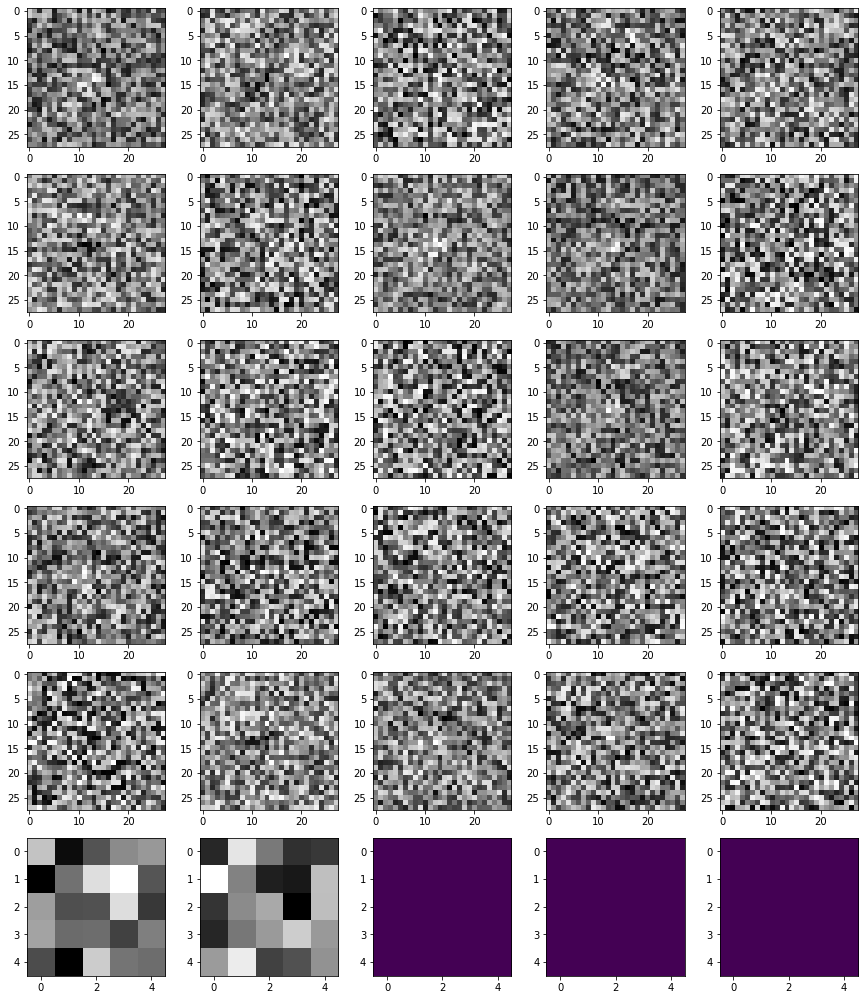

In [7]:
# Visualising the weights matrix after training
# Some abstract features can be seens
ann.show()

In [8]:
# Testing 
ann.test(test_data,test_label)

Accuracy:	0.9793 

Confusion Matrix:
[[8927   45]
 [ 162  866]] 

Classification Report: 

	 precision 		 recall 		 f1 				 support
0 	 0.9821762570139729 	 0.9949843958983504 	 0.9885388405957588 	 8927
1 	 0.9506037321624589 	 0.8424124513618677 	 0.8932439401753482 	 866
total 	 0.966389994588216 	 0.918698423630109 	 0.9408913903855536 	 9793


The accuracy, precision and recall from Perceptron are:(0.9801, 0.9461, 0.8550). 

Those of Neural Net are 97.93, 95.06 (for class 1, which is number 7) and 84.24 (same). The accuracy and recall drop by a little, while precision incrases a bit.  

The weights matrix and biases are initialised according to $r=4\sqrt{\frac{6}{M_{l-1}+M_l}}$ with uniform distribution [ -r , r ]  and $ \sigma^2 = 16 \times \frac{2}{M_{l-1}+M_l} $ with normal distribution N(0,$\sigma^2$). This is called Xavier Initialisation, used when activation function is Logistic activation.

There is also Xavier Initialisation for Tanh activation function and He Initialisation for Relu activation function. For simplicity, they are not used in this code.

The reason of using this initialisation scheme is that the input would be amplified by $𝑀_{𝑙−1} \cdot var(𝑤_i^l)$ times, thus the signal could be over amplified or reduced after being passed through multuple layers.

The training time is increased significantly from 2.59s to 1min 56s.

The learning converges much slower than Perceptron, reaching its highest accuracy level at Batch 5, whereas Perceptron reaches that at Batch 1.

Next we further modify learning rate and iteration number to try to achieve better results.

In [10]:
ann1 = ANN(dimensions=[784,25,2],activation=['sigmoid','sigmoid'],
           loss='mse',learning_rate=0.1,max_iterations = 2)
ann1.print_details()

No. inputs:	784
No. outputs:	2
No. hidden layers:	1
Hidden layer size:	[25]
Max iterations:	2
Learning rate:	0.1
Hyperparameter Alpha:	0
Dropout rate:	0
Normalisation:	uniform
Loss function:	mse


In [11]:
%%time
ann1.train(train_data,train_label)

Batch 1
Accuracy:	0.9744 

Confusion Matrix:
[[53632   103]
 [ 1433  4832]] 

Classification Report: 

	 precision 		 recall 		 f1 				 support
0 	 0.9739762099337147 	 0.9980831860053968 	 0.9858823529411764 	 53632
1 	 0.979128672745694 	 0.771268954509178 	 0.8628571428571429 	 4832
total 	 0.9765524413397044 	 0.8846760702572873 	 0.9243697478991597 	 58464
Batch 2
Accuracy:	0.9835333333333334 

Confusion Matrix:
[[53217   518]
 [  470  5795]] 

Classification Report: 

	 precision 		 recall 		 f1 				 support
0 	 0.9912455529271518 	 0.9903601004931609 	 0.9908026288842137 	 53217
1 	 0.9179470932995406 	 0.9249800478850758 	 0.9214501510574018 	 5795
total 	 0.9545963231133462 	 0.9576700741891184 	 0.9561263899708077 	 59012
Batch 3
Accuracy:	0.98485 

Confusion Matrix:
[[53501   234]
 [  675  5590]] 

Classification Report: 

	 precision 		 recall 		 f1 				 support
0 	 0.9875406083874778 	 0.9956452963617753 	 0.991576391656087 	 53501
1 	 0.9598214285714286 	 0.89225857940941

For simplicity again, I just directly increase iteration number and learning rate simultaneously and the result is amazingly much better, with highest accuracy reached at Batch 11 of 99.21%, the precision and recall for class 1 are 96.74% and 95.69%, respectively. 

The learning converges much faster with accuracy of 97.44% reached at Batch 1, higher than that of previous Neural Net of 94.94% at Batch 1.

In [13]:
ann1.test(test_data,test_label)

Accuracy:	0.9892 

Confusion Matrix:
[[8952   20]
 [  88  940]] 

Classification Report: 

	 precision 		 recall 		 f1 				 support
0 	 0.9902654867256637 	 0.9977708426214891 	 0.9940039973351099 	 8952
1 	 0.9791666666666666 	 0.914396887159533 	 0.9456740442655935 	 940
total 	 0.9847160766961651 	 0.956083864890511 	 0.9698390208003518 	 9892


Accuracy on test set reaches a similiar high level of 98.92%, precision and recall are 97.91% and 91.43, respectively.

Since we are dealing with classification task, cross entropy loss function is appropriate to be used as loss function, with softmax activation function for the output layer. 

In [12]:
ann2 = ANN(dimensions=[784,25,2],activation=['sigmoid','softmax'],
           loss='crossentropy',learning_rate=0.1,max_iterations = 2)
ann2.print_details()

No. inputs:	784
No. outputs:	2
No. hidden layers:	1
Hidden layer size:	[25]
Max iterations:	2
Learning rate:	0.1
Hyperparameter Alpha:	0
Dropout rate:	0
Normalisation:	uniform
Loss function:	crossentropy


In [14]:
%%time
ann2.train(train_data,train_label)

Batch 1
Accuracy:	0.9823833333333334 

Confusion Matrix:
[[53584   151]
 [  906  5359]] 

Classification Report: 

	 precision 		 recall 		 f1 				 support
0 	 0.9833730959809139 	 0.9971899134642226 	 0.9902333102333102 	 53584
1 	 0.972595281306715 	 0.8553870710295292 	 0.9102335456475584 	 5359
total 	 0.9779841886438145 	 0.9262884922468759 	 0.9502334279404343 	 58943
Batch 2
Accuracy:	0.98555 

Confusion Matrix:
[[53176   559]
 [  308  5957]] 

Classification Report: 

	 precision 		 recall 		 f1 				 support
0 	 0.9942412684167228 	 0.9895970968642411 	 0.9919137466307277 	 53176
1 	 0.9142111724984653 	 0.9508379888268157 	 0.9321649323214145 	 5957
total 	 0.954226220457594 	 0.9702175428455284 	 0.9620393394760711 	 59133
Batch 3
Accuracy:	0.9861333333333333 

Confusion Matrix:
[[53638    97]
 [  735  5530]] 

Classification Report: 

	 precision 		 recall 		 f1 				 support
0 	 0.9864822614165119 	 0.9981948450730437 	 0.9923039923039922 	 53638
1 	 0.9827616847343167 	 0.8

Using Cross Entropy loss function and softmax activation function at the output layer, we get the accuracy of 99.49% at Batch 11, the corresponding precision and recall are 97.81% and 97.30%. This Neural Net's learning converges even faster than the previous ann1, reaching 98.23% at Batch 1, as opposed to that of 97.44% of ann1.

Results on test set are pretty good as well. They are listed below.

In [15]:
ann2.test(train_data,train_label)

Accuracy:	0.9933666666666666 

Confusion Matrix:
[[53675    60]
 [  338  5927]] 

Classification Report: 

	 precision 		 recall 		 f1 				 support
0 	 0.9937422472367763 	 0.9988834093235321 	 0.9963061959386718 	 53675
1 	 0.9899782862869551 	 0.946049481245012 	 0.9675155076722167 	 5927
total 	 0.9918602667618657 	 0.9724664452842721 	 0.9819108518054442 	 59602


Once again for simplicity, we explore the effect of Relu activation function with 2 iterations. The tuning of learning rate and hidden layer size, nodes number in hidden layers would also have different effects on the Neural Net but we will ignore them for the moment. We will also do a classification of 10 digits at the end.

In [18]:
ann3 = ANN(dimensions=[784,25,2],activation=['relu','sigmoid'],
           loss='mse',learning_rate=0.1,max_iterations = 2)
ann3.print_details()

No. inputs:	784
No. outputs:	2
No. hidden layers:	1
Hidden layer size:	[25]
Max iterations:	2
Learning rate:	0.1
Hyperparameter Alpha:	0
Dropout rate:	0
Normalisation:	uniform
Loss function:	mse


In [19]:
%%time
ann3.train(train_data,train_label)

Batch 1
Accuracy:	0.97435 

Confusion Matrix:
[[53651    84]
 [ 1455  4810]] 

Classification Report: 

	 precision 		 recall 		 f1 				 support
0 	 0.9735963415961965 	 0.998436773052945 	 0.9858601078637647 	 53651
1 	 0.9828361258684103 	 0.767757382282522 	 0.8620844161663233 	 4810
total 	 0.9782162337323034 	 0.8830970776677335 	 0.9239722620150439 	 58461
Batch 2
Accuracy:	0.9863333333333333 

Confusion Matrix:
[[53549   186]
 [  634  5631]] 

Classification Report: 

	 precision 		 recall 		 f1 				 support
0 	 0.9882989129431741 	 0.9965385689029497 	 0.992401638280917 	 53549
1 	 0.9680247550283652 	 0.8988028731045491 	 0.9321304419798048 	 5631
total 	 0.9781618339857696 	 0.9476707210037494 	 0.9622660401303609 	 59180
Batch 3
Accuracy:	0.9841166666666666 

Confusion Matrix:
[[53594   141]
 [  812  5453]] 

Classification Report: 

	 precision 		 recall 		 f1 				 support
0 	 0.9850751755321104 	 0.9973760119103006 	 0.9911874312240502 	 53594
1 	 0.9747944225956382 	 0.87

The learning of ann3 converges almost as fast as ann1. They both reach around 97.44% at Batch 1. Ann3 perform3 better than ann1, with highest accuracy of 99.39% at Batch 11. My guess is that because ann1 uses 2 sigmoid function, which means the gradients of the weights matrix between input layer and hidden layer could not exceed 1/16 due to gradients vanishing and leads to ineffective learning. However, ann3 is beaten by ann2 with a slight 0.1%. This could be we are using differnt loss function and activation function at the output layer. Let's try the combination of relu, softmax and Cross Entropy.  

In [22]:
ann4 = ANN(dimensions=[784,25,2],activation=['relu','softmax'],
           loss='crossentropy',learning_rate=0.1,max_iterations = 2)
ann4.print_details()

No. inputs:	784
No. outputs:	2
No. hidden layers:	1
Hidden layer size:	[25]
Max iterations:	2
Learning rate:	0.1
Hyperparameter Alpha:	0
Dropout rate:	0
Normalisation:	uniform
Loss function:	crossentropy


In [23]:
%%time
ann4.train(train_data,train_label)

Batch 1
Accuracy:	0.9665666666666667 

Confusion Matrix:
[[53689    46]
 [ 1960  4305]] 

Classification Report: 

	 precision 		 recall 		 f1 				 support
0 	 0.9647792413161063 	 0.9991439471480413 	 0.9816609376142762 	 53689
1 	 0.9894277177660308 	 0.6871508379888268 	 0.8110399397136397 	 4305
total 	 0.9771034795410685 	 0.8431473925684341 	 0.896350438663958 	 57994
Batch 2
Accuracy:	0.9835833333333334 

Confusion Matrix:
[[53331   404]
 [  581  5684]] 

Classification Report: 

	 precision 		 recall 		 f1 				 support
0 	 0.9892231785131325 	 0.9924816227784498 	 0.9908497217758043 	 53331
1 	 0.9336399474375822 	 0.9072625698324023 	 0.9202622844653121 	 5684
total 	 0.9614315629753574 	 0.949872096305426 	 0.9555560031205582 	 59015
Batch 3
Accuracy:	0.9776 

Confusion Matrix:
[[53631   104]
 [ 1240  5025]] 

Classification Report: 

	 precision 		 recall 		 f1 				 support
0 	 0.9774015417980354 	 0.998064576160789 	 0.9876249930943042 	 53631
1 	 0.9797231429128485 	 0.802

In [24]:
ann4.test(test_data,test_label)

Accuracy:	0.9852 

Confusion Matrix:
[[8877   95]
 [  53  975]] 

Classification Report: 

	 precision 		 recall 		 f1 				 support
0 	 0.9940649496080627 	 0.9894115024520731 	 0.9917327672885711 	 8877
1 	 0.9112149532710281 	 0.9484435797665369 	 0.9294566253574834 	 975
total 	 0.9526399514395454 	 0.968927541109305 	 0.9605946963230272 	 9852


Unfortunately ann4 does not outperform ann3. I think the potential reason is that relu reduces the nonlinearity and also it is prefered in deeper neural nets for the avoidance of gradients vanishing. 

Before I finish this long and tedious report, let's briefly see how it performs on 10 digits recognition. We also need to reload our data as we have modified their labels for binary classification.

In [31]:
train = pd.read_csv(r'D:\Jupyter Notebooks\Course semester 2\DP and NN\Assignment2\mnist_train.csv',header = None)
train_data = train.values 
train_label = train_data.T[0]     # Get the training labels 
train_data = train_data[:,1:]     # Get the training data
train_data = train_data/255.0     # Compress numbers into [0,1]

In [32]:
test = pd.read_csv(r'D:\Jupyter Notebooks\Course semester 2\DP and NN\Assignment2\mnist_test.csv',header = None)
test_data = test.values 
test_label = test.values.T[0]     # Get the testing labels 
test_data = test.values[:,1:]     # Get the testing data
test_data = test_data/255.0     

In [40]:
ann5 = ANN(dimensions=[784,36,25,10],activation=['sigmoid','relu','softmax'],
           loss='crossentropy',learning_rate=0.1,max_iterations = 2)
ann5.print_details()

No. inputs:	784
No. outputs:	10
No. hidden layers:	2
Hidden layer size:	[36, 25]
Max iterations:	2
Learning rate:	0.1
Hyperparameter Alpha:	0
Dropout rate:	0
Normalisation:	uniform
Loss function:	crossentropy


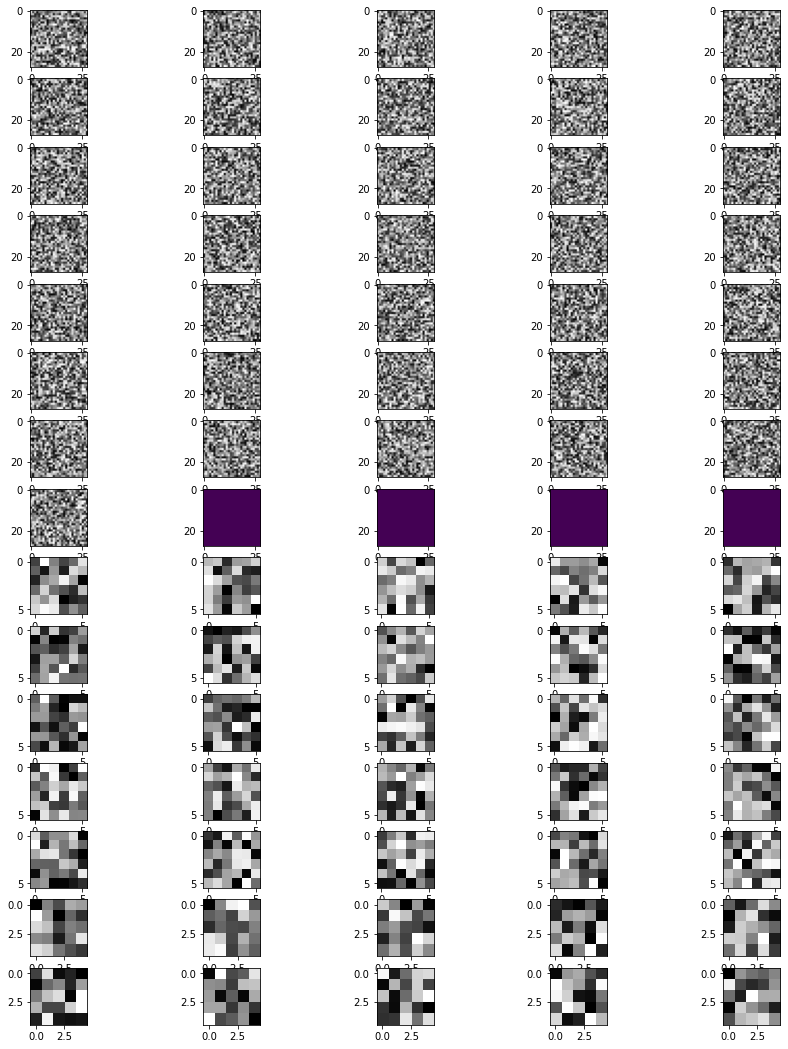

In [42]:
ann5.show()

In [43]:
%%time
ann5.train(train_data,train_label)

Batch 1
Accuracy:	0.8538333333333333 

Confusion Matrix:
[[5705    1   10   24   23   92   12    9   33   14]
 [   3 6536   20   79   25   28    4   12   26    9]
 [ 155   12 4691  417   75  108  202  122  127   49]
 [  27    6   59 5695   20   96   10   60   57  101]
 [  23   39   11    7 5499   27   97    4   29  106]
 [ 119   11    5  799  100 4126   19    5  176   61]
 [ 238   18   19   80   43  203 5104    2  207    4]
 [  97   47   20   52  194   48    3 5569    7  228]
 [  72  105   24  458  172  101   10    4 4570  335]
 [  73   39    0  125 1793   22    1  130   31 3735]] 

Classification Report: 

	 precision 		 recall 		 f1 				 support
0 	 0.8760749385749386 	 0.9631943271990545 	 0.9175713711298753 	 5705
1 	 0.9592016436747872 	 0.9694452684663305 	 0.9642962525818827 	 6536
2 	 0.9654249845647253 	 0.787344746559248 	 0.8673384487380974 	 4691
3 	 0.7361685625646329 	 0.9288859892350351 	 0.8213744861902359 	 5695
4 	 0.6922205438066465 	 0.9412872304005477 	 0.797765849

Batch 7
Accuracy:	0.8892166666666667 

Confusion Matrix:
[[5722    0   38    7    9   44   16    5   80    2]
 [   0 6245   32   35   18    4    1  103  301    3]
 [  64   14 5364   50   21    8   17  324   86   10]
 [  52    6  164 5473    1   35    4  134  233   29]
 [  13    4  137    4 5428   19   31   19  153   34]
 [ 234    2   39  906   11 3867   19   31  293   19]
 [ 180   12   67    3   29  125 5122    5  375    0]
 [  12    8   38   26   77   25    1 5928   34  116]
 [  71   17   52   38    7   34    7   87 5525   13]
 [  47    4   15   50  775   24    1  111  243 4679]] 

Classification Report: 

	 precision 		 recall 		 f1 				 support
0 	 0.8947615324472243 	 0.9660644943440824 	 0.9290469232018184 	 5722
1 	 0.9893852978453739 	 0.9262830020765351 	 0.9567948521525969 	 6245
2 	 0.9021190716448032 	 0.9003021148036254 	 0.9012096774193548 	 5364
3 	 0.830248786407767 	 0.8926765617354429 	 0.8603316827792187 	 5473
4 	 0.8513174404015057 	 0.9291338582677166 	 0.888525126

In [44]:
ann5.test(test_data,test_label)

Accuracy:	0.9243 

Confusion Matrix:
[[ 923    1    6    2    0    3   32    2    6    5]
 [   0 1087    4    4    0    1    2    2   33    2]
 [   9    2  947   19    3    1   17    9   20    5]
 [   2    1    7  947    0   17    2    9   20    5]
 [   0    0    4    0  814    2   34    1    6  121]
 [   7    1    1   20    5  801   26    5   17    9]
 [   3    3    2    1    1    4  937    1    6    0]
 [   1    7   23    4    1    0    1  934    5   52]
 [   5    2    4   15    5    6    8    3  885   41]
 [   1    2    3    7    4    5    3    4   12  968]] 

Classification Report: 

	 precision 		 recall 		 f1 				 support
0 	 0.9705573080967402 	 0.9418367346938775 	 0.955981356809943 	 923
1 	 0.9828209764918626 	 0.9577092511013215 	 0.970102632753235 	 1087
2 	 0.9460539460539461 	 0.9176356589147286 	 0.9316281357599607 	 947
3 	 0.929342492639843 	 0.9376237623762376 	 0.9334647609659932 	 947
4 	 0.9771908763505402 	 0.8289205702647657 	 0.896969696969697 	 814
5 	 0.953571

The result is not bad, the accuracy reaches 93.69% at Batch 10. The accuracy is not very stable as it sometimes suddenly drops from over 90% to blow 90% like in Batch 8 and 9. The accuracy on test set is 92.43%. Our Neural Net shows no overfitting at this stage so there is no need to add dropout method.

I have tried multiple Neural Nets for 10 digits classification. When I use 2 relu function in the hidden layer, the result is horribly bad for no reason. So I pick the Neural Net that works well in the notebook.

Have a look at the visualisation of the weights matrix before we finally finish, this time some interesting features seem to have emerged!

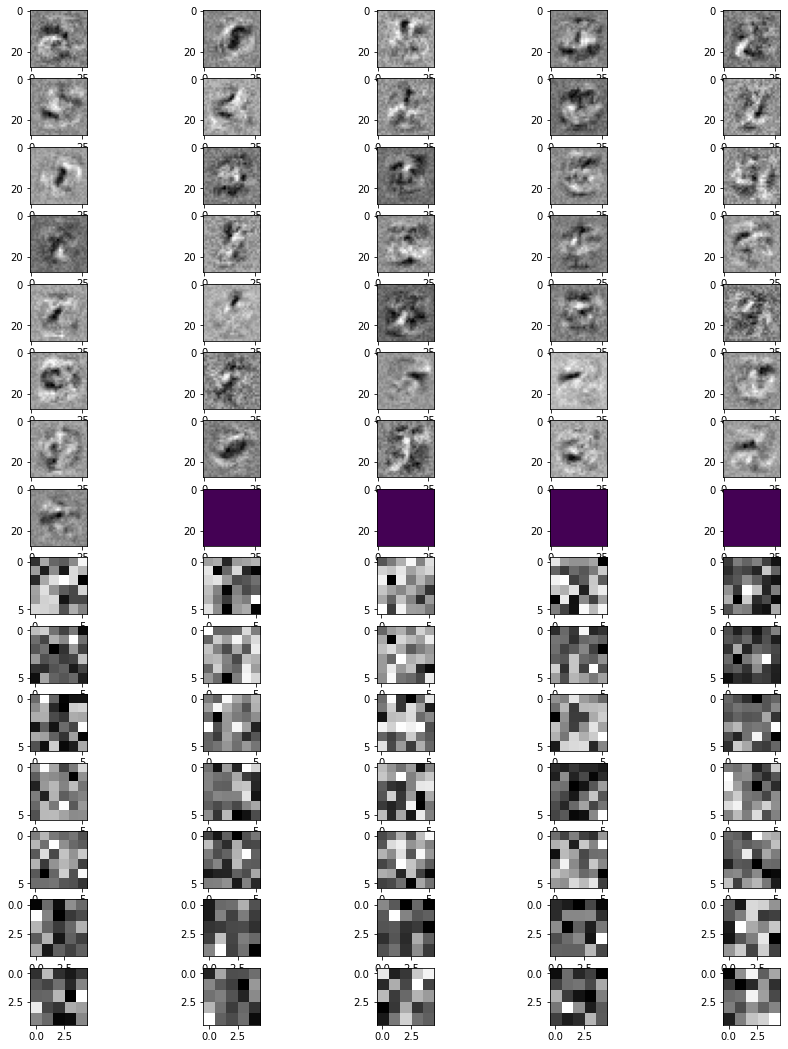

In [45]:
ann5.show()

## Summary Tables

|ANN      |highest accuracy on|training set and corresponding|precision and recall||||
|------|------|------|------||||
||Accuracy|Precision|Recall|Result reached at|Converge at|Structure|
|ann|0.9791666666666666|0.9533538239016452|0.8416600159616919|6/6 |5|sigmoid(25) sigmoid(2) mse lr(0.01) Epoch(1)|
|ann1|0.9921333333333333|0.9674035823785703|0.9569034317637669|11/12|2|sigmoid(25) sigmoid(2) mse lr(0.1) Epoch(2)|
|ann2|0.9949166666666667|0.9781771501925546|0.973024740622506|11/12|4|sigmoid(25) softmax(2) crossentropy lr(0.1) Epoch(2)|
|ann3|0.99395 |0.9706539074960128|0.9714285714285714|11/12|5|relu(25) softmax(2) mse lr(0.1) Epoch(2)|
|ann4|0.9882 | 0.9231003502360287|0.9675977653631285|12/12|7|relu(25) softmax(2) crossentropy lr(0.1) Epoch(2)|
|ann5(10 nodes)|0.9369|F1 score:0.9361372753851||10/12|10|sigmoid(36) relu(25) softmax(10) crossentropy lr(0.1) Epoch(2)|


|ANN|On test set|||
|------|------|------|------|
||Accuracy  |Precision  | Recall |
|ann|0.9793 |0.9506037321624589|0.8424124513618677|
|ann1|0.9892 | 0.9791666666666666|0.914396887159533|
|ann2|0.9933666666666666 |0.9899782862869551|0.946049481245012|
|ann3|Missing|Missing  | Missing |
|ann4|0.9852|0.9112149532710281|0.9484435797665369|
|ann5(10 nodes)|0.9243 |F1 score: 0.9241135793059589||

|Perceptron|highest accuracy on|training set and corresponding|precision and recall||
|------|------|------|------||
||Accuracy|Precision|Recall|Result reached at|
|p uniform|0.9818|0.9478787878787879|0.8737430167597765|6/6|
|p normal|0.9823666666666667|0.9413459908459061|0.8863527533918595|6/6|
|p batch|0.98155|0.955975954738331|0.863048683160415|6/12|
|p 10 nodes|0.8785833333333334|||5/6|